In [6]:
import ast
import networkx as nx
import importlib
import utils
import style
import graph
import copy
importlib.reload(utils)
importlib.reload(style)
importlib.reload(graph)
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import xml.dom.minidom
from IPython.display import Image

In [7]:
images_folder = 'images/'
filename_test = 'code_samples/test-redundant-vars.py'

In [8]:
with open('code_samples/test-redundant-vars.py', 'r') as file:
    code = file.read()

2024-04-23 00:36:11.939 draw.io[82157:4295033] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


images/test-redundant-vars-before.drawio -> images/test-redundant-vars-before.png


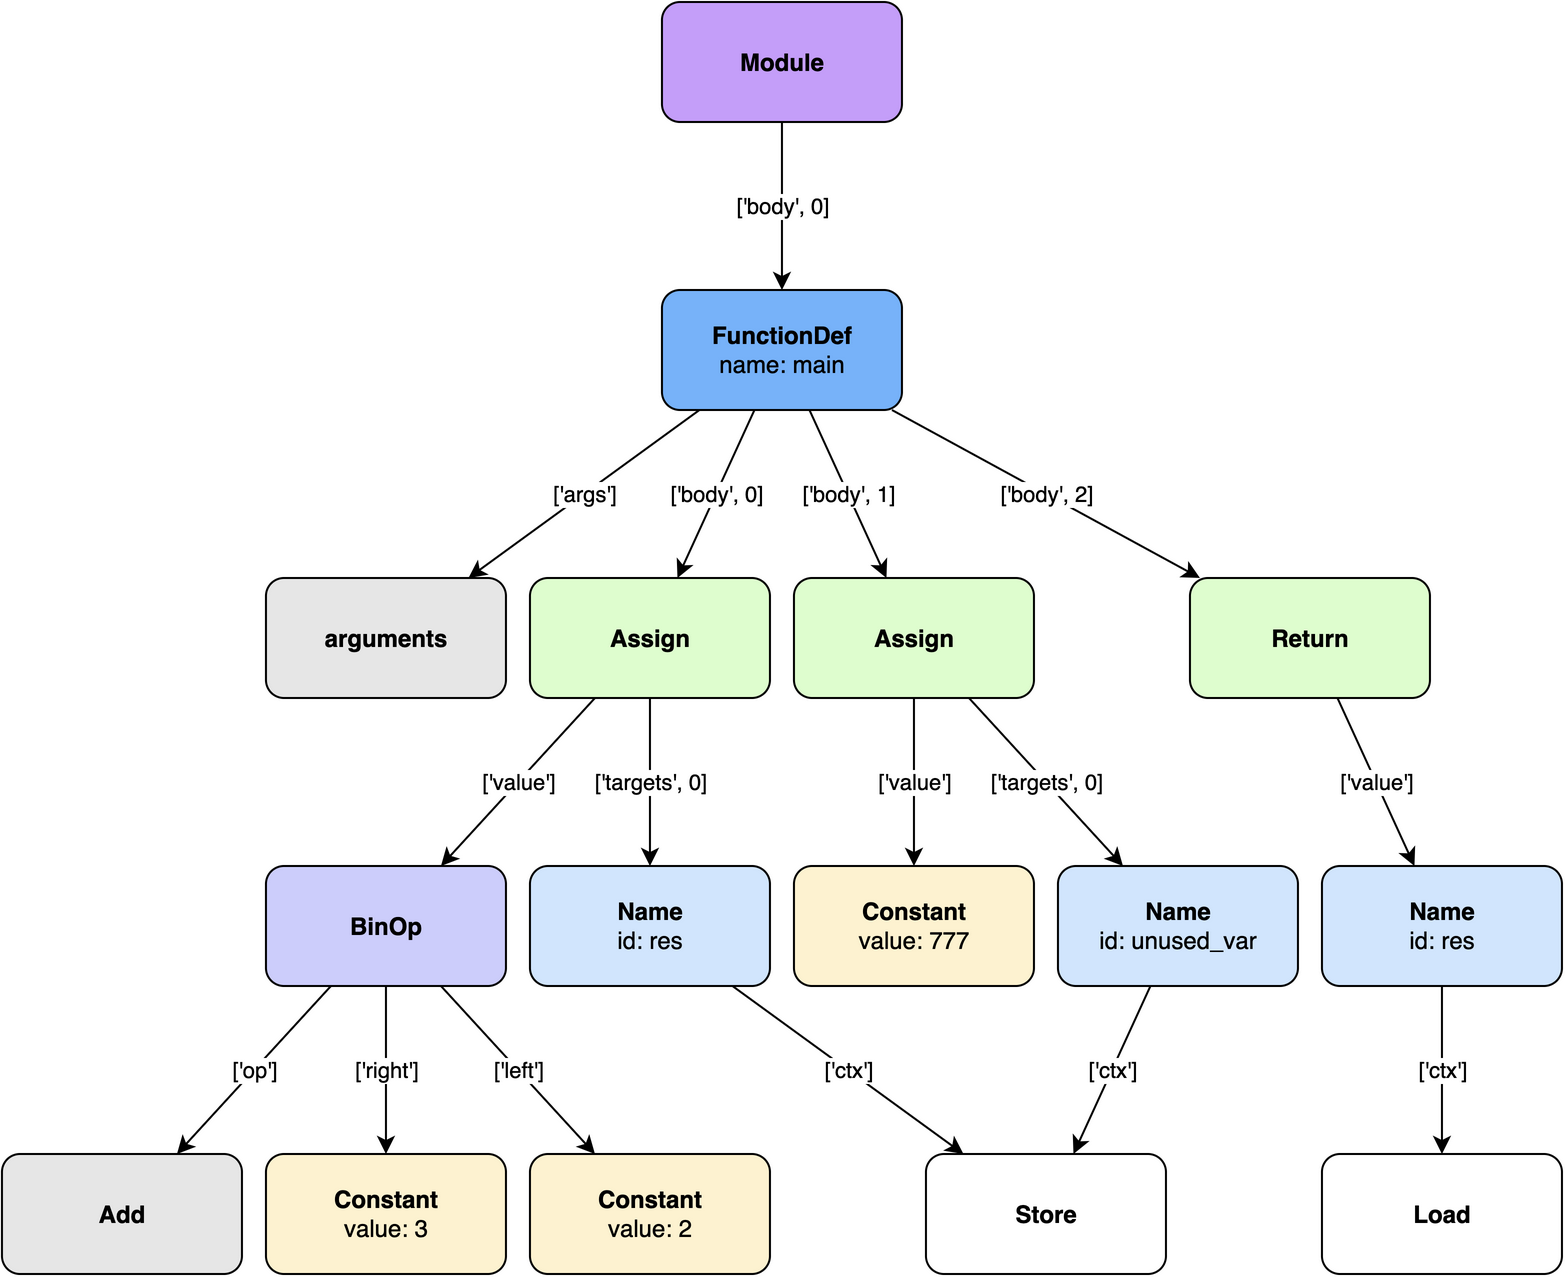

In [9]:
importlib.reload(style)
importlib.reload(graph)
from graph import OurGraph

from style import OurGraphToXML
import os 
import ast

def vis_drawio(g: OurGraph, output_file_name: str = 'images/temp-ex'):
    """
    to use this function you need to install drawio and cleate an alias for its command line interface.
    for mac:
        drawio="/Applications/draw.io.app/Contents/MacOS/draw.io"
    """
    mxfile = OurGraphToXML(y_scaling=2, x_scaling=1).graph_to_xml(g)
    xml_str = xml.dom.minidom.parseString(ET.tostring(mxfile)).toprettyxml()
    
    output_file = f'{output_file_name}.png'
    filename    = f'{output_file_name}.drawio'

    with open(filename, 'w') as file:
        file.write(xml_str) 

    bashCommand = f"/Applications/draw.io.app/Contents/MacOS/draw.io -x -f png --scale 2   -o {output_file} {filename}"
    os.system(bashCommand) 
    return Image(output_file)     

G = OurGraph.from_file(filename_test)
vis_drawio(G, 'images/test-redundant-vars-before')

def main():
    res = 2 + 3
    unused_var = 777
    return res

_____________
def main():
    res = 2 + 3
    return res



2024-04-23 00:36:17.225 draw.io[82167:4295292] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


images/test-redundant-vars-after.drawio -> images/test-redundant-vars-after.png


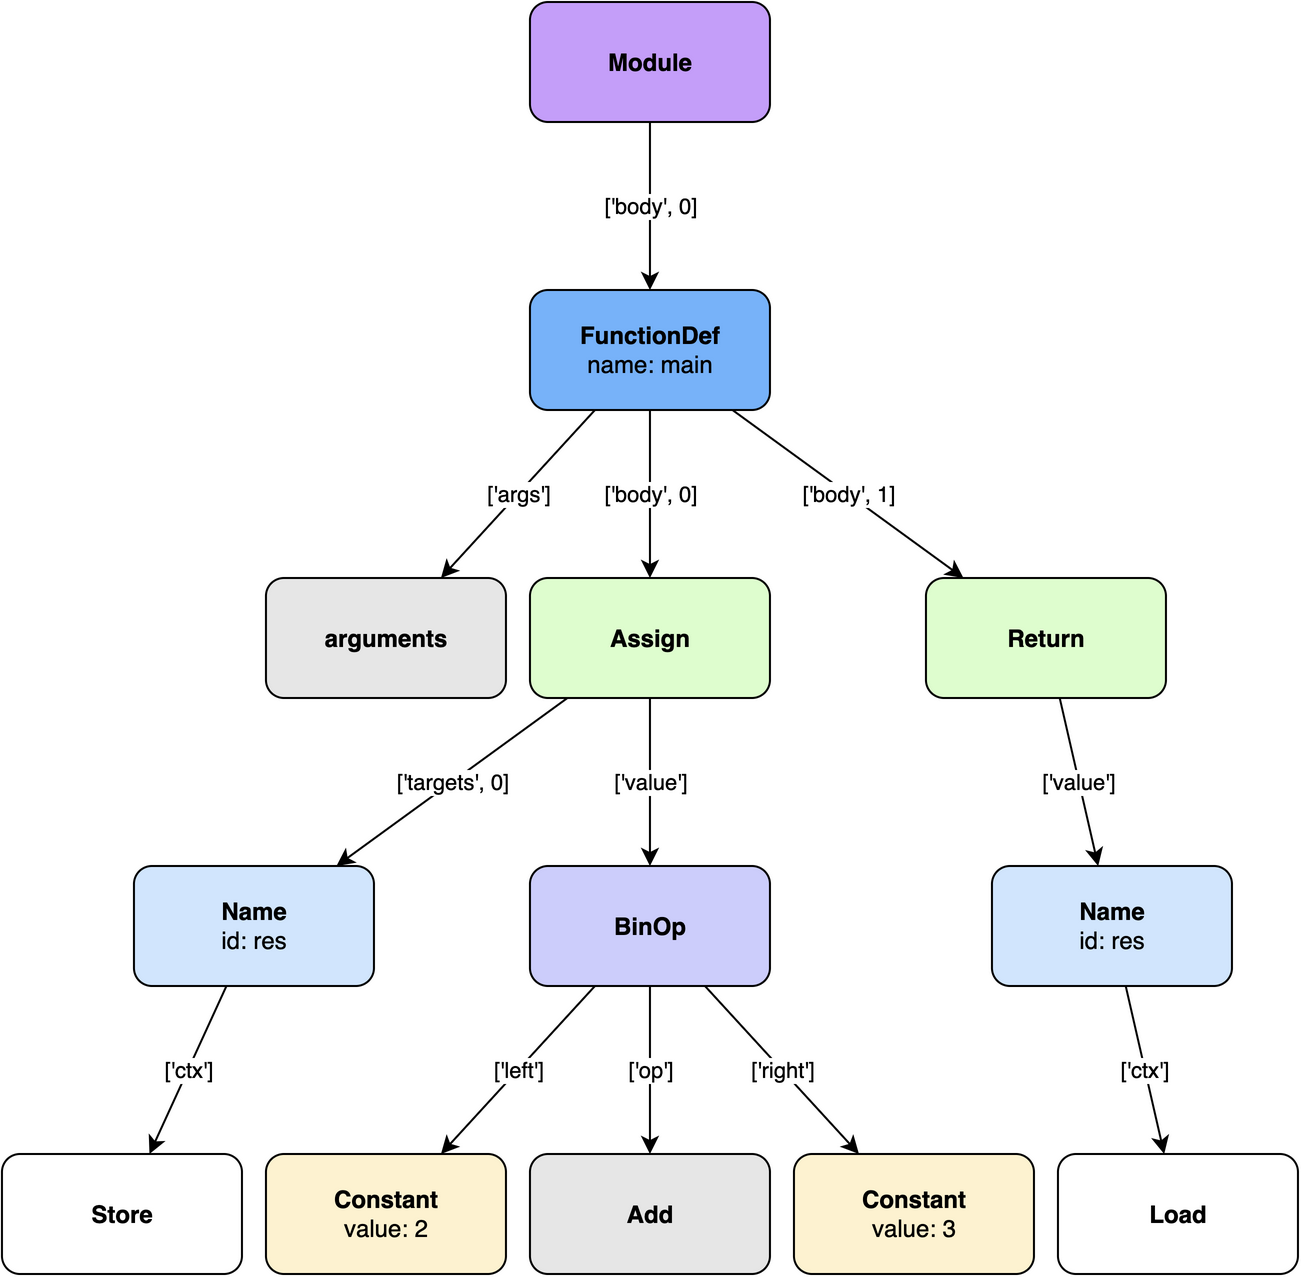

In [10]:
import transforms
importlib.reload(transforms)
from transforms import remove_redundant_variables

for node_id, node in G.ast_nodes.items():
    if isinstance(node, ast.Call):
        break

G_new = copy.deepcopy(G)
G_new.refresh()
removed = remove_redundant_variables(G_new)
print(G.to_source())
print('_____________')
print(removed.to_source())
vis_drawio(removed, 'images/test-redundant-vars-after')


In [17]:
import metrics
importlib.reload(metrics)
from metrics import calculate_metrics, analyze_imports

get_metrics = calculate_metrics(code)
num_imports, import_list = analyze_imports(code)

print("Metrics Results:")
print(get_metrics)
print(f"Number of Unique Imports: {num_imports}")
print(f"Imported Modules: {import_list}")


Metrics Results:
{'average_complexity': 0, 'lines_of_code': 0, 'maintainability_index': 100.0}
Number of Unique Imports: 0
Imported Modules: set()
